## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
import email
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support, classification_report 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


2024-06-14 15:36:40.061158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 15:36:40.061253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 15:36:40.231207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2d7f9171-c173-4200-860c-499a1c530ae8)
GPU 1: Tesla T4 (UUID: GPU-585c8c3c-d42a-f90a-b8c6-8cc42f6ba661)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.1 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('/kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [5]:
len(phishing_messages_1)

3976

In [6]:
phishing_messages_1[500]

"From: J. Rodney Chesson \nChesson Family Corporation,\nLiberia.\nEmail: jrchesson@rediffmail.com\n\nKindest attention,\n\nI am very sorry for the informal manner in which this mail is reaching you. This is necessitated by my urgent need to reach a dependable and trustworthy foreign partner. This request may seem strange and unsolicited but I crave your indulgence and pray that you take my request very serious.\n\nI am Mr. J. Rodney Chesson, the first son of Late J. J. F. Chesson (Liberian Minister of Justice 1979 to 1980). On April 22, 1980, my father along with 12 other Liberian Government officials was assassinated as a result of a military coup that toppled the government of President William\nR. Tolbert, Jr. May his soul rest in Eternal Peace. Since then, my family has always been seen as a symbol of peace in Liberia. \n\nI received information from a reliable source that described your country as being economically conducive for investment and her people as transparent and trustw

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = '/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 email-spam-dataset-extended/ham_zipped/main_ham


In [8]:
ham_messages[5]

'\n[can\'t think of how I\'d be running\nafoul of the spam filters with this\npost, so here\'s the second try...]\n\nKissinger\'s book _Does America Need\na Foreign Policy?_ provides a few\nhandy abstractions:\n\n> The ultimate dilemma of the statesman is to strike a balance between\n> values ["idealism"] and interests ["realism"] and, occasionally,\n> between peace and justice.\n\nAlso, he views historical American\napproaches to foreign policy as a\nbundle of three fibers:\n\nHamiltonian - We should only get\n  involved in foreign adventures\n  to preserve balances of power.\n\nWilsonian - We should only get\n  involved in foreign adventures\n  to further democracy, etc.\n\nJacksonian - We should never get\n  involved in foreign adventures.\n  Unless we\'re attacked.  Then we\n  go Rambo.\n\nHe has tactfully left out the hard\nrealists*; as for the rest I gather\nwilsonians play the idealists, and\nhamiltonians act where values and\ninterests intersect, and jacksonians \nact only whe

In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = '/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [10]:
phishing_messages_2[:5]

['<html>\n\n<head>\n<meta http-equiv="Content-Language" content="en-us">\n<meta name="GENERATOR" content="Microsoft FrontPage 5.0">\n<meta name="ProgId" content="FrontPage.Editor.Document">\n<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">\n<title>Norton AD</title>\n</head>\n\n<body>\n\n<table border="3" cellspacing="3" width="469" cellpadding="3" bgcolor="#000080"  bordercolor="#FFFFFF" style="border-collapse: collapse" bordercolordark="#FFFFFF">\n  <tr>\n    <td width="447">&nbsp;\n      <table border="1" width="100%" bgcolor="#FFFFFF" bordercolor="#000080">\n        <tr>\n          <td width="100%" align="center"><font face="Impact" size="4" color="#CC0000">ATTENTION:\n            This is a MUST for <u>ALL</u> Computer Users!!!</font></td>\n        </tr>\n      </table>\n      <p align="center"><font size="3" face="Verdana"><b>&nbsp;<font color="#FFFFFF">*NEW\n      - Special Package Deal!*</font></b></font></p>\n      <table border="8" width="100%" height=

In [11]:
## getting meassages from html like messages 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [12]:
phishing_messages_3[0]

"Norton AD\n\n\n\n\n\n\n\n\n\n\n\xa0\n      \n\n\n\n\nATTENTION:\n            This is a MUST for \nALL\n Computer Users!!!\n\n\n\n\n\n\n\xa0\n*NEW\n      - Special Package Deal!*\n\n\n\n\n\n\nNorton\n            SystemWorks 2002 Software Suite\n\n            -\nProfessional Edition\n-\n\n\n\n\n\n\n\n\n\n\nIncludes\n            Six - \nYes 6!\n - Feature-Packed Utilities\nALL\n            for \n1\n\n            Special \nLOW\n\n            Price!\n\n\n\n\n\n\n\n\n\n\nThis Software Will:\n- Protect your\n            computer from unwanted and \n hazardous\n viruses\n- Help secure your\n            private & valuable information\n- Allow you to transfer files\n            and send e-mails \n safely\n- Backup your ALL your data quick and\n            easily\n- Improve your PC's performance w/\nsuperior\n\n            integral diagnostics!\n\n\n\n\n\xa0\n      \n\n\n\n\n\n\n6\n\n\nFeature-Packed Utilities\n\n\n1\n\n\n Great\n            Price\n \n\n\n\n            A\n \n$300+\n \n Combined 

In [13]:
## removing \n  from phishing_messages_3
phishing_messages_4=[]
for ph_message in phishing_messages_3 : 
    cleaned=ph_message.replace('\n','')
    phishing_messages_4.append(cleaned)

In [14]:
phishing_messages_4[0]

"Norton AD\xa0      ATTENTION:            This is a MUST for ALL Computer Users!!!\xa0*NEW      - Special Package Deal!*Norton            SystemWorks 2002 Software Suite            -Professional Edition-Includes            Six - Yes 6! - Feature-Packed UtilitiesALL            for 1            Special LOW            Price!This Software Will:- Protect your            computer from unwanted and  hazardous viruses- Help secure your            private & valuable information- Allow you to transfer files            and send e-mails  safely- Backup your ALL your data quick and            easily- Improve your PC's performance w/superior            integral diagnostics!\xa0      6Feature-Packed Utilities1 Great            Price             A $300+  Combined Retail Value            YOURS for Only $29.99!<Includes            FREE Shipping!> Don't fall prey to destructive viruses    or hackers!Protect\xa0 your computer and your valuable  information    and->            CLICK HERE to Order Yours NOW

In [15]:
## removing \xa0  from phishing_messages_3

phishing_messages_5=[]
for ph_message in phishing_messages_4 : 
    cleaned=ph_message.replace('\xa0','')
    phishing_messages_5.append(cleaned)
    

In [16]:
phishing_messages_5[0]

"Norton AD      ATTENTION:            This is a MUST for ALL Computer Users!!!*NEW      - Special Package Deal!*Norton            SystemWorks 2002 Software Suite            -Professional Edition-Includes            Six - Yes 6! - Feature-Packed UtilitiesALL            for 1            Special LOW            Price!This Software Will:- Protect your            computer from unwanted and  hazardous viruses- Help secure your            private & valuable information- Allow you to transfer files            and send e-mails  safely- Backup your ALL your data quick and            easily- Improve your PC's performance w/superior            integral diagnostics!      6Feature-Packed Utilities1 Great            Price             A $300+  Combined Retail Value            YOURS for Only $29.99!<Includes            FREE Shipping!> Don't fall prey to destructive viruses    or hackers!Protect your computer and your valuable  information    and->            CLICK HERE to Order Yours NOW! <-Click      h

In [17]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = '/kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)}')

# Optional: Print the first message to check


Total messages extracted from  emails-enron-legal-mails.mbox : 4279


In [18]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


Tana:

Coastal Oil & Gas Canada Inc. is NOT authorized to trade US power products.  
It is not a current trading partner and not FERC approved.

Pacific Gas & Electric Company -- ENRON SALES only for East and West power 
pursuant to on-line GTCs
TXU Electric Company -- ENRON SALES only for East and West power pursuant to 
on-line GTCs

GPU Advanced Resources, Inc. is authorized to trade all US power products 
pursuant to the on-line GTCs.

Thanks,

Leslie

 


 ####################################################################################################
Debra,
 I have looked over the cancelled GISB that CES tried to put in place with 
FGU.  Nothing in there of note.  Therefore, please prepare our standard GISB, 
do not use any of their language.  When it is ready, please email to Michelle 
Klein and to Jared Kaiser .  
----- Forwarded by Dan J Hyvl/HOU/ECT on 03/21/2001 11:12 AM -----

	Jared Kaiser
	03/14/2001 02:31 PM
		 
		 To: Dan J Hyvl/HOU/ECT@ECT
		 cc: 
		 Subject: GISB 

In [19]:
# legal_emils[600:605]

In [20]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# Example usage with the email samples
# cleaned_emails = extract_and_clean_emails(emails)
# print(cleaned_emails)
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [21]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

for bullets
---------------------- Forwarded by Susan Scott/ET&S/Enron on 11/22/2000 
11:17 AM ---------------------------


Susan Scott
Donoho/ET&S/Enron@ENRON, Jeffery Fawcett/ET&S/Enron@ENRON, Steven 
Harris/ET&S/Enron@ENRON, Kevin Hyatt/ET&S/Enron@Enron, Lorraine 
Lindberg/ET&S/Enron@ENRON, TK Lohman/ET&S/Enron@ENRON, Michelle 
Lokay/ET&S/Enron@Enron, Christine Stokes/ET&S/Enron@ENRON, Drew Fossum@ENRON, 
Maria Pavlou/ET&S/Enron@ENRON, Mary Kay Miller/ET&S/Enron@ENRON, Glen 
Hass/ET&S/Enron@ENRON, Mary Darveaux/ET&S/Enron@ENRON, Julia 
White/ET&S/Enron@ENRON, Sheila Nacey/ET&S/Enron@ENRON, Ramona 
Betancourt/ET&S/Enron@ENRON, Gerry Medeles/ET&S/Enron@ENRON
I just received a call from Nancy Bagot informing me that FERC has issued a 
draft order suspending our proposed Transport Options tariff sheets until May 
1, 2001 and accepting them subject to the outcome of a technical conference.  
The technical conference is to take place within 120 days of the order and 
will address issues 

### Getting phishing emails from  emails-phishing-nazario.mbox

In [22]:


# Path to the mbox file
phishing_nazario_file_path = "/kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of messages: {len(phishing_nazario_messages)}")




Number of messages: 2279


In [23]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that causes Unicodeerror')


removed 141 messages that causes Unicodeerror


In [24]:
len(cleaned_phishing_nazario_messages)

2138

In [25]:
# let's have a look on sample of cleaned_phishing_nazario_messages
for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

Return-Path: <member@account.org>
X-Original-To: user@login.example.com
Delivered-To: user@login.example.com
Received: from mail.example.org (mail.example.org [192.168.4.9])
	by example.com (Postfix) with ESMTP id 19E12468E8
	for <user@login.example.com>; Fri, 23 Feb 2007 14:30:33 -0500 (EST)
Received: from mail.example.org (mail.example.org [192.168.6.4])
	by mail.example.org (Postfix) with ESMTP id 077A7131F866
	for <user@example.com>; Fri, 23 Feb 2007 14:30:33 -0500 (EST)
Received: from dgasidc0.csqrd.com (unknown [65.69.17.76])
	by mail.example.org (Postfix) with ESMTP id 0973A6FA1CA
	for <user@example.com>; Fri, 23 Feb 2007 14:30:32 -0500 (EST)
Received: from User ([218.153.96.114]) by dgasidc0.csqrd.com with Microsoft SMTPSVC(6.0.3790.1830);
	 Fri, 23 Feb 2007 13:30:30 -0600
From: "Amazon.com"<member@account.org>
Subject: Please Update Your Profile - Personal Information Error
Date: Sat, 24 Feb 2007 05:20:28 +0900
MIME-Version: 1.0
Content-Type: text/plain;
	charset="Windows-1251

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [26]:

# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)

print(len(cleaned_phishing_nazario_messages_text))


2116


In [27]:
cleaned_phishing_nazario_messages_text[:5]

['in 1841 stars battle    Tour de France in 1872 in 1923 \n\nR0lGODlhZQJsAfPrAAkFAKbK8ICAgABgwACAwCCAwECAwECgwGCgwICgwIDAwP/78AAA/////wAAAAAAACH5BAQAAAAALAAAAABVAmMBAAT/sMlJq7046827/2AojmRpnmiqrmzrvnAsz3Rt33iu73zv/8CgcEgs\nGo/IpHLJbDqf0Kh0Sq1ar9isdsvter+dhXhMLpvFgYACQQC73/C4/BpAFAiDvH7P7/fngIGCg4QxAQV+\niYp9BYWOj5ApdXcEBAUGCQtFC2mdaRaeoaKhUwmLp6cIkausrRcBBouqQwF9BhZ4qHy3Uaa6v3wBrsPE\njrWovDd2BcyXwg3He8kTucAD0zkJBtvczxrR1r/YxeTlXwvVqTiIwRLgeePp4j2x7Rro4dbe5vz9WAj6\nbsgb8OzdNVz5xt2ot2ffBV/5dM3yR7EiFHzAFMIYWNAWwnAa/2sw1OPQAruIp0JaXMkyiMEBCNKc3KOp\nBkd3HisMREavT0kKL1HuqtmyqNEfEPU0wunTxk1oOSkg4LbNDwGqmHrawxBU6AACP4+KHTsDIJ+JDWbm\nSVAhTQIECBQEIGriqUFeC97GBOoHrQVObE+ogZtg7oWRecJKMOtVz1XDZCNLjoEYJoXKExPsvPZsgYFm\nzAzUPAR6GzM/oRnruaX6a8c+qpY1YxsADwHZzQqCZha4wQI2fgwUhDvQANyfnEYpXy5msvPnLVp/JSqd\nrWdUwhb4qSldV+WqfoS9VKVWuOPKr6UxlQVVHSjjcOPLn09ffmG60PPr95BUac0zElSWiP8w2y0WkYCK\nNDJeA/J8dl5T7anXFR+FoeKXBP01xtl+HHb4SiJgZTAhHwVo1wd3B4aTRl8MLnIVhHelBUx3Z11gooZn\n4efhjs9h1JeODQi42UsoJqTijXuoslkeL9pj0AE

In [28]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages

# Example usage:

cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)
# for cleaned_message in cleaned_messages:
#     print(cleaned_message)


In [29]:
## removing \n and 0x from meassages 
cleaned_phishing_nazario_messages_text_2=[]
for m in cleaned_phishing_nazario_messages_text_1 :
    m=m.replace('\n','')
    m=re.sub('[0x\d]+','',m)
    m=m.replace(',','')
    cleaned_phishing_nazario_messages_text_2.append(m)
    
    

In [30]:
cleaned_phishing_nazario_messages_text_2[:5]

['in  stars battle Tour de France in  in ',
 'Dear eBay User  After fraud complaints from the eBay members the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take  days period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. RegardsSafeharbor Department eBay Inc.',
 "Dear valued customer O

## Getting all data into a dataframe 

In [31]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,\nme:\n> >Spam is *the* tool for dissident new...
1,0,Chuck Murcko wrote:\n> > The usual crud. Why ...
2,0,<html><head><!--\n\n CLICK HERE to read t...
3,0,"On Wednesday 31 July 2002 12:02, Satelle, Stev..."
4,0,URL: http://scriptingnews.userland.com/backiss...
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [32]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_5+cleaned_phishing_nazario_messages_text_2
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8380,1,Dear PayPal Member Your account has been rando...
8381,1,Web-Based Email :: View :: eBay sent this mess...
8382,1,Dear eBay user eBay Customer Support Team requ...
8383,1,Dear PayPal Member Your account has been rando...


In [33]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [34]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
2899,0,"URL: http://www.newsisfree.com/click/-4,826803..."
3579,0,"URL: http://www.newsisfree.com/click/-0,859765..."
5390,1,Direct Email Blaster The program will send mai...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [35]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8385
Name: count, dtype: int64

In [36]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [37]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4645

In [38]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1964 duplicated phishing messages in data 


In [39]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2681 duplicated ham messages in data 


In [40]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [41]:
shuffled_df['phishing'].value_counts()

phishing
0    8545
1    6421
Name: count, dtype: int64

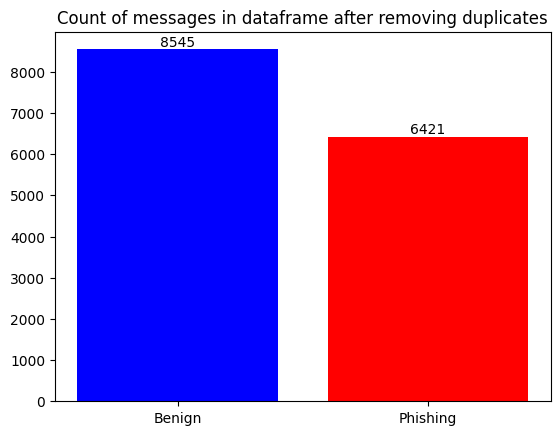

In [42]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [43]:

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6421 phishing messages and 8545 ham messages in data after removing Duplicates


In [44]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [45]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
6038,0,<html><head><!--\n\n\n CLICK HERE to read...
4426,1,Do you take credit cards?If you do you will ma...
8465,0,"Juan,\r\n\r\nI did not go to Fidelity. It was..."
6265,1,Hello Unlimited International Telephone Call M...


In [46]:
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [47]:
train_labels.value_counts()

phishing
0    6824
1    5148
Name: count, dtype: int64

In [48]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 11972 message


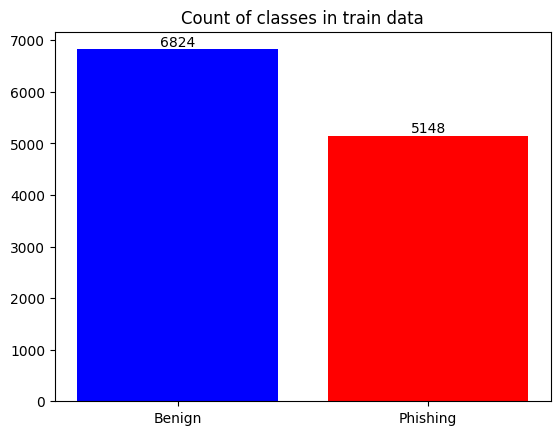

In [49]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [50]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 2994 message


In [51]:
print(test_labels.value_counts())


phishing
0    1721
1    1273
Name: count, dtype: int64


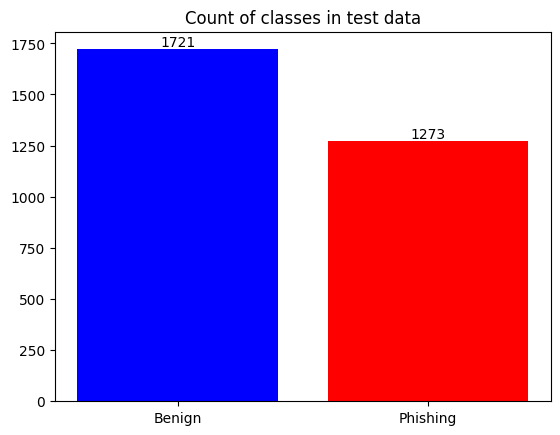

In [52]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [53]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [54]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[930,
 39,
 1555,
 265,
 243,
 76,
 361,
 113,
 460,
 266,
 38,
 194,
 320,
 460,
 113,
 220,
 205,
 111,
 842,
 130,
 96,
 72,
 73,
 76,
 499]

In [55]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1082 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [56]:
## making Text vectorization layer 
## 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024)

In [57]:
text_vectorizer.adapt(train_text)

In [58]:
words_in_vocab=text_vectorizer.get_vocabulary()

In [59]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'as',
 'on',
 'with',
 'be']

In [60]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['dasbrandworldstdcom',
 'darveauxetsenronenron',
 'danmark',
 'dance',
 'damned',
 'dame',
 'dachshund',
 'czophyaolcom',
 'cuteftp',
 'cutaia',
 'curtail',
 'current2',
 'current1',
 'cunniffe',
 'critique',
 'crisatdtd',
 'crippling',
 'crenshawhouectect',
 'crawling',
 'craiggannettdwtcom']

In [61]:
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1183, ...,    0,    0,    0]])>

### Creating an Embedding using an Embedding Layer


In [62]:
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [63]:
embed(text_vectorizer([sentence]))[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04884246, -0.0342712 , -0.02610887, -0.01872492,  0.02441804,
       -0.00598506,  0.02024722,  0.0095328 ,  0.03311462,  0.01977405,
        0.04097215, -0.00660587,  0.01358483, -0.02365189, -0.00600082,
       -0.04365924,  0.03415563, -0.01897876, -0.01069247,  0.04579667,
        0.01110661, -0.00819981,  0.04788804, -0.00966799, -0.03662403,
        0.03904487,  0.04065139,  0.04970017,  0.02464088, -0.03272755,
        0.00339284,  0.01248646,  0.00022336, -0.03993039,  0.00874652,
        0.03905613, -0.03117869,  0.0097062 ,  0.02658382,  0.01286772,
       -0.01989203,  0.0079519 ,  0.0232998 ,  0.00396695, -0.00718216,
        0.03558213, -0.02865388,  0.04255421,  0.02236868, -0.01215836,
        0.01493127,  0.02775314,  0.03338328,  0.02693779, -0.04910591,
       -0.00363929, -0.0460253 ,  0.0079687 ,  0.04749687,  0.00519692,
        0.0374951 ,  0.00735247,  0.00498701,  0.04643733, -0.03237374,
        0.012602

## Satrting Experiments 

In [64]:
## creating functions for callbacks 
def create_checkpoint_callback(file_path):
    cnn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=False,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return cnn_model_checkpoint_callback
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

## Long-Term Short Memory (LSTM) model  

In [65]:
import tensorflow as tf 

inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed(x)
x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

> #### creating tensorboard , early stopping and checkpoint callpacks 

In [66]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint.keras')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [67]:
type(train_text)

pandas.core.series.Series

In [68]:
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.6721 - loss: 0.5846 - val_accuracy: 0.9637 - val_loss: 0.1422
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9739 - loss: 0.0989 - val_accuracy: 0.9704 - val_loss: 0.1152
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9578 - loss: 0.1206 - val_accuracy: 0.9424 - val_loss: 0.1441
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9867 - loss: 0.0428 - val_accuracy: 0.9774 - val_loss: 0.0733
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9941 - loss: 0.0198 - val_accuracy: 0.9803 - val_loss: 0.0777
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9956 - loss: 0.0136 - val_accuracy: 0.9790 - val_loss: 0.0874
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9977 - loss: 0.0063 - val_accuracy: 0.9785 - val_loss: 0.1024
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9976 - loss: 0.0070 - 

In [69]:

lstm_model_1.summary()

Model: "lstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 1024, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,834,565 (29.89 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,223,044 (19.92 MB)

In [70]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


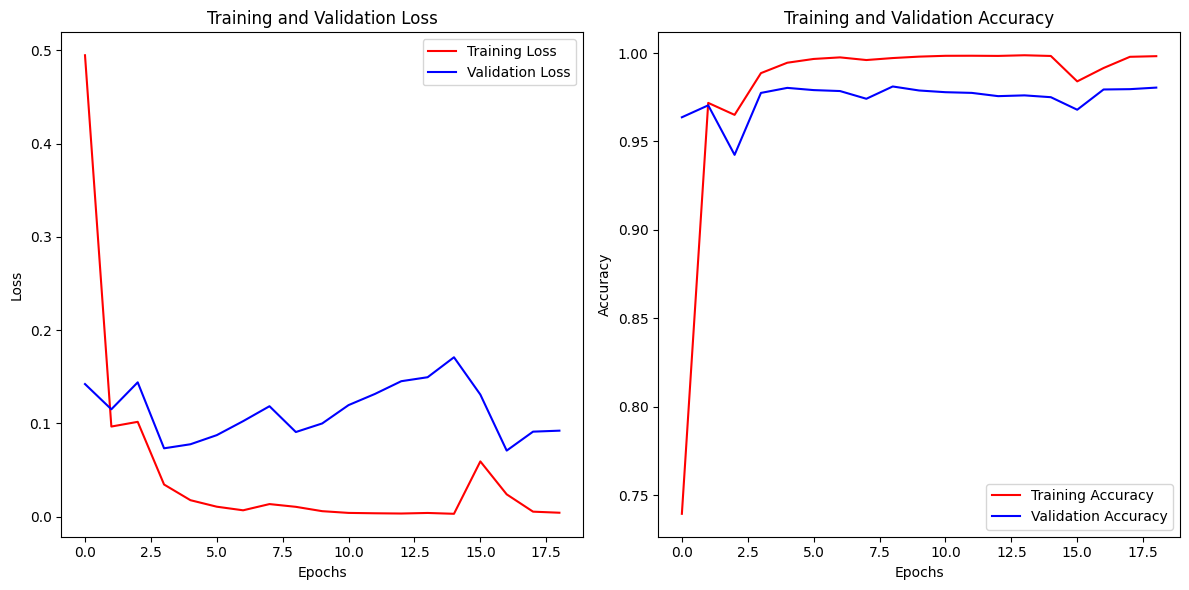

In [71]:
# plotting training curves for lsmt_model_1

plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [72]:
test_text.shape

(2994,)

In [73]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


(2994, 1024, 1)

In [74]:
import seaborn as sns

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [75]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# function to create other important metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate various classification metrics using scikit-learn.

    Args:
        y_true (list or np.array): The true labels.
        y_pred (list or np.array): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.

    Note:
        - The function assumes binary classification (0 and 1 labels).
        - The true labels and predicted labels should be of the same length.
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    FDR = fp / (tp + fp) if (tp + fp) != 0 else 0  # False Discovery Rate
    FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
    FOR = fn / (fn + tn) if (fn + tn) != 0 else 0  # False Omission Rate
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate
    NPV = tn / (tn + fn) if (tn + fn) != 0 else 0  # Negative Prediction Value
    

    metrics = {
        'False Discovery Rate (FDR)': FDR,
        'False Negative Rate (FNR)': FNR ,
        'False Omission Rate (FOR)': FOR,
        'False Positive Rate (FPR)': FPR,
        'Negative Prediction Value (NPV)': NPV
        
    }

    return metrics

In [76]:
test_labels.shape

(2994,)

In [77]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

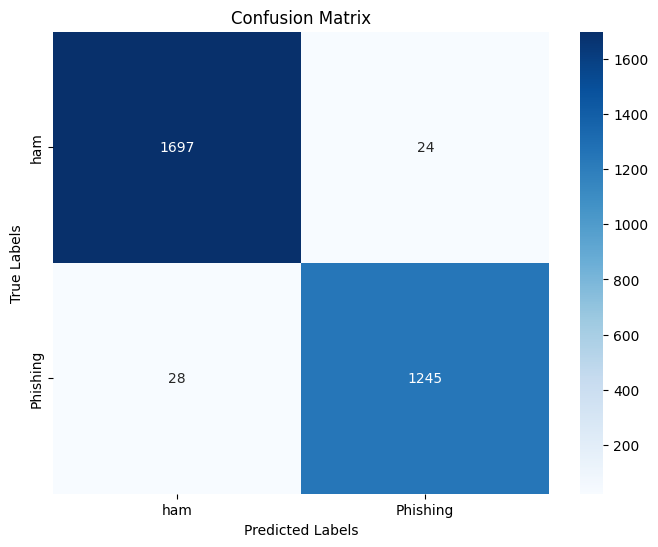

In [78]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)

In [79]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)
print('metrics for lstm_model_1\n')

for key , value in lstm_model_1_results.items() : 
    print(key,value,'\n')

metrics for lstm_model_1

accuracy 0.9826319305277221 

precision 0.9826283491710182 

recall 0.9826319305277221 

f1 0.9826283457754026 



In [80]:
# classification report of model lstm_model_1 

report_1=classification_report(test_labels.values,avg_pred_labels_lstm1)
print(f"classification report for lstm_model_1 \n\n {report_1}")

classification report for lstm_model_1 

               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1721
           1       0.98      0.98      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [81]:
# calculating other metrices for lstm_model_1
print('other metrics for lstm_model_1\n')

for key , value in calculate_metrics(test_labels.values,avg_pred_labels_lstm1).items():
    print(key,value,'\n')

other metrics for lstm_model_1

False Discovery Rate (FDR) 0.018912529550827423 

False Negative Rate (FNR) 0.02199528672427337 

False Omission Rate (FOR) 0.016231884057971015 

False Positive Rate (FPR) 0.013945380592678676 

Negative Prediction Value (NPV) 0.983768115942029 



### Creating tensorboard 
>##### to visualize tensorboard download tensorboards.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 

In [82]:
## zipping tensorbard directory to download it and visualize it on pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs


  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/events.out.tfevents.1718379526.1ecee8c51f11.34.1.v2 (deflated 75%)
  adding: kaggle/working/logs/lstm_1/train/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/train/events.out.tfevents.1718379506.1ecee8c51f11.34.0.v2 (deflated 87%)


### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [83]:
lstm_model_1.layers

[<InputLayer name=input_layer, built=True>,
 <TextVectorization name=text_vectorization, built=True>,
 <Embedding name=Embedding_Name-123, built=True>,
 <LSTM name=lstm_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [84]:
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[ 1.77047551e+00 -1.57278943e+00 -1.19213331e+00 ...  1.28435099e+00
  -1.58646071e+00  2.54843211e+00]
 [ 2.83436477e-01 -2.04338342e-01 -6.39132932e-02 ...  1.99325949e-01
  -1.02772504e-01 -5.47806136e-02]
 [-1.61429700e-02 -1.90305710e-02 -1.95574854e-02 ... -3.23431101e-03
  -2.73114052e-02 -3.56037468e-02]
 ...
 [-6.77340152e-03 -1.75260175e-02 -5.03650084e-02 ...  8.32292531e-03
  -1.46865956e-02  2.87206005e-02]
 [ 2.74167880e-02  5.10547981e-02  8.65742341e-02 ... -8.75435695e-02
   8.26452374e-02  9.59624574e-02]
 [ 1.12172840e-02 -1.60194971e-02  1.09563814e-02 ... -1.50256613e-02
   2.39968626e-03 -6.11690581e-02]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [85]:
import io
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [86]:
# Create 1-dimensional convolutional layer to model sequences
from keras import regularizers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embed(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 

outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
cnn_model.summary()


Model: "Conv1D_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1020, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,582,689 (9.85 MB)

 Trainable params: 2,582,689 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='checkpoints/cnn_checkpoint.keras')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [88]:
# fitting cnn model 
cnn_history=cnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9228 - loss: 0.4586 - val_accuracy: 0.9803 - val_loss: 0.0922
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9953 - loss: 0.0596 - val_accuracy: 0.9830 - val_loss: 0.0776
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9971 - loss: 0.0415 - val_accuracy: 0.9790 - val_loss: 0.0776
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9972 - loss: 0.0357 - val_accuracy: 0.9800 - val_loss: 0.0768
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9980 - loss: 0.0316 - val_accuracy: 0.9816 - val_loss: 0.0720
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9977 - loss: 0.0297 - val_accuracy: 0.9813 - val_loss: 0.0680
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9972 - loss: 0.0262 - val_accuracy: 0.9800 - val_loss: 0.0669
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9973 - loss: 0.0240 - val_accu

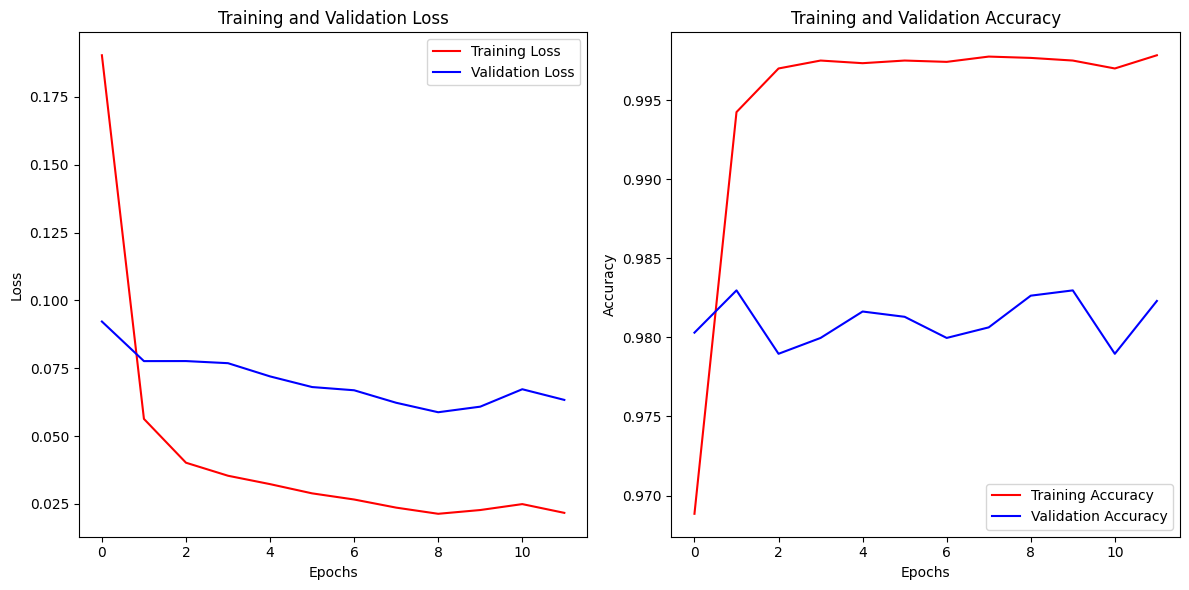

In [89]:
# plotting training curves for cnn model 


plot_loss_and_accuracy_curves(cnn_history)


### Evaluating CNN model

In [90]:
pred_labels_cnn=cnn_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_cnn=np.round(avg_pred_labels_cnn.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


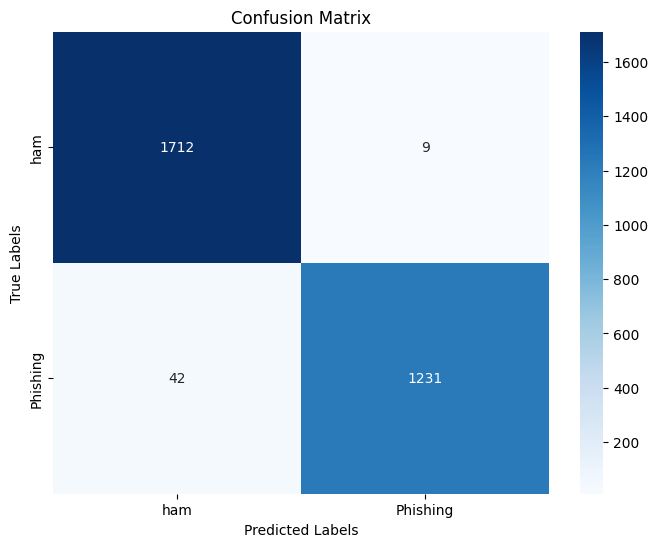

In [91]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels.values)

In [92]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels.values)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9829659318637275, 'precision': 0.9832719414188433, 'recall': 0.9829659318637275, 'f1': 0.982996893941616}


In [93]:
# classification report of  cnn_model  
report_2=classification_report(test_labels.values,avg_pred_labels_cnn)
print(f"classification report for cnn_model \n\n {report_2}")

classification report for cnn_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.99      0.97      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [94]:
# calculating other metrices for cnn_model
print('other metrics for cnn_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_cnn).items():
    
    print(key,value,'\n')

other metrics for cnn_model

False Discovery Rate (FDR) 0.007258064516129033 

False Negative Rate (FNR) 0.032992930086410056 

False Omission Rate (FOR) 0.02394526795895097 

False Positive Rate (FPR) 0.005229517722254503 

Negative Prediction Value (NPV) 0.976054732041049 



## GRU model 

In [95]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1024, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,473 (9.92 MB)

 Trainable params: 2,601,473 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [97]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.6925 - loss: 0.5604 - val_accuracy: 0.9667 - val_loss: 0.1063
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9740 - loss: 0.0808 - val_accuracy: 0.9698 - val_loss: 0.0882
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9858 - loss: 0.0426 - val_accuracy: 0.9787 - val_loss: 0.0795
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9930 - loss: 0.0208 - val_accuracy: 0.9793 - val_loss: 0.0912
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9923 - loss: 0.0250 - val_accuracy: 0.9780 - val_loss: 0.0911
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9965 - loss: 0.0107 - val_accuracy: 0.9791 - val_loss: 0.0928
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9967 - loss: 0.0074 - val_accuracy: 0.9790 - val_loss: 0.1036
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9971 - loss: 0.0056 - 

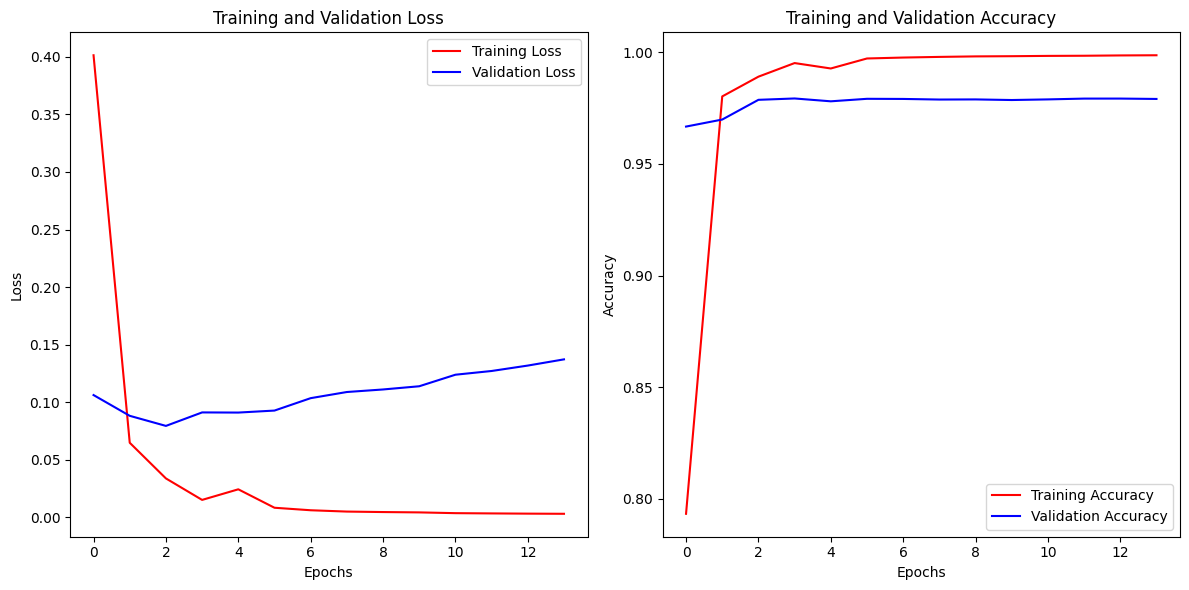

In [98]:
# plotting training curves for GRU model 


plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [99]:

pred_labels_gru=gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


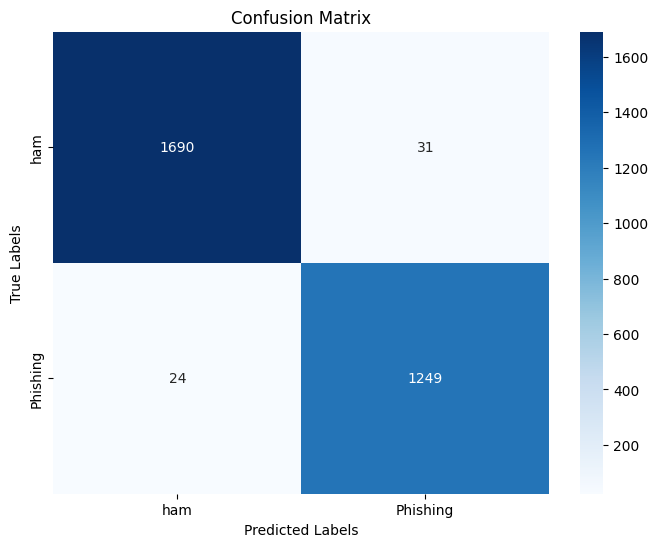

In [100]:
# plotting confusion matrix for gru_model 
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels.values)

In [101]:
# calculating metrices for gru_model
gru_results=calculate_results(avg_pred_labels_gru,test_labels.values)
print('metrics for gru_model\n')

for key ,value in gru_results.items() : 
    print(key,value,'\n')

metrics for gru_model

accuracy 0.981629926519706 

precision 0.9816279618445268 

recall 0.981629926519706 

f1 0.9816234600095088 



In [102]:
# classification report of gru_model 
report_3=classification_report(test_labels.values,avg_pred_labels_gru)
print(f"classification report for gru_model \n\n {report_3}")

classification report for gru_model 

               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1721
           1       0.98      0.98      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [103]:
# calculating other metrices for gru_model
print('other metrics for gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru).items():
    
    print(key,value,'\n')

other metrics for gru_model

False Discovery Rate (FDR) 0.02421875 

False Negative Rate (FNR) 0.018853102906520033 

False Omission Rate (FOR) 0.014002333722287048 

False Positive Rate (FPR) 0.01801278326554329 

Negative Prediction Value (NPV) 0.9859976662777129 



## SimpleRNN model

In [104]:
# # Set random seed and create embedding layer (new embedding layer for each model)
# tf.random.set_seed(42)
# simplernn_model_embedding = layers.Embedding(input_dim=20000,
#                                      output_dim=128,
#                                      embeddings_initializer="uniform",
#                                      input_length=1024,
#                                      name="simple_rnn_embedding")

# # Build an RNN using the GRU cell
# inputs = layers.Input(shape=(1,), dtype="string")
# x = text_vectorizer(inputs)
# x = simplernn_model_embedding(x)
# x = layers.SimpleRNN(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   

# x = layers.Dense(64, activation="relu")(x) 
# outputs = layers.Dense(1, activation="sigmoid")(x)
# simple_rnn_model = tf.keras.Model(inputs, outputs, name="simple_rnn_model")
# simple_rnn_model.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])
# simple_rnn_model.summary()

In [105]:
# simple_rnn_model_history=simple_rnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
#             callbacks=[create_tensorboard_callback(file_path='logs/simple_rnn_model_tensorboard'),early_stopping_callback,
#                        create_checkpoint_callback(file_path='checkpoints/simple_rnn_model.keras')])

In [106]:


# plot_loss_and_accuracy_curves(simple_rnn_model_history)

### Evaluating SimpleRNN model


In [107]:
# pred_labels_simple_rnn_model=simple_rnn_model.predict(test_text.values)


In [108]:

# # Average over the time steps
# avg_pred_labels_simple_rnn_model = np.mean(pred_labels_simple_rnn_model, axis=1)

# avg_pred_labels_simple_rnn_model=np.round(avg_pred_labels_simple_rnn_model.flatten())
# simple_rnn_model_results=calculate_results(avg_pred_labels_simple_rnn_model,test_labels)
# print('Metrics for simple_rnn_model')
# for key,value in simple_rnn_model_results.items():
#     print(key,value,'\n')

In [109]:
# plot_confusion_matrix(y_pred=simple_rnn_model_results,y_true=test_labels.values)

In [110]:
# # calculating other metrices for simple_rnn_model
# print('Other metrics for simple_rnn_model\n')
# for key , value in calculate_metrics(test_labels.values,avg_pred_labels_simple_rnn_model).items():
    
#     print(key,value,'\n')

## Bidirectonal LSTM model 

In [111]:
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [112]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.8555 - loss: 0.2925 - val_accuracy: 0.9749 - val_loss: 0.0744
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9840 - loss: 0.0447 - val_accuracy: 0.9623 - val_loss: 0.1045
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.9893 - loss: 0.0327 - val_accuracy: 0.9736 - val_loss: 0.0795
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9940 - loss: 0.0173 - val_accuracy: 0.9773 - val_loss: 0.0732
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9946 - loss: 0.0130 - val_accuracy: 0.9726 - val_loss: 0.0988
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9952 - loss: 0.0112 - val_accuracy: 0.9729 - val_loss: 0.1107
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9975 - loss: 0.0055 - val_accuracy: 0.9770 - val_loss: 0.0948
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9957 - loss: 0.0137 - 

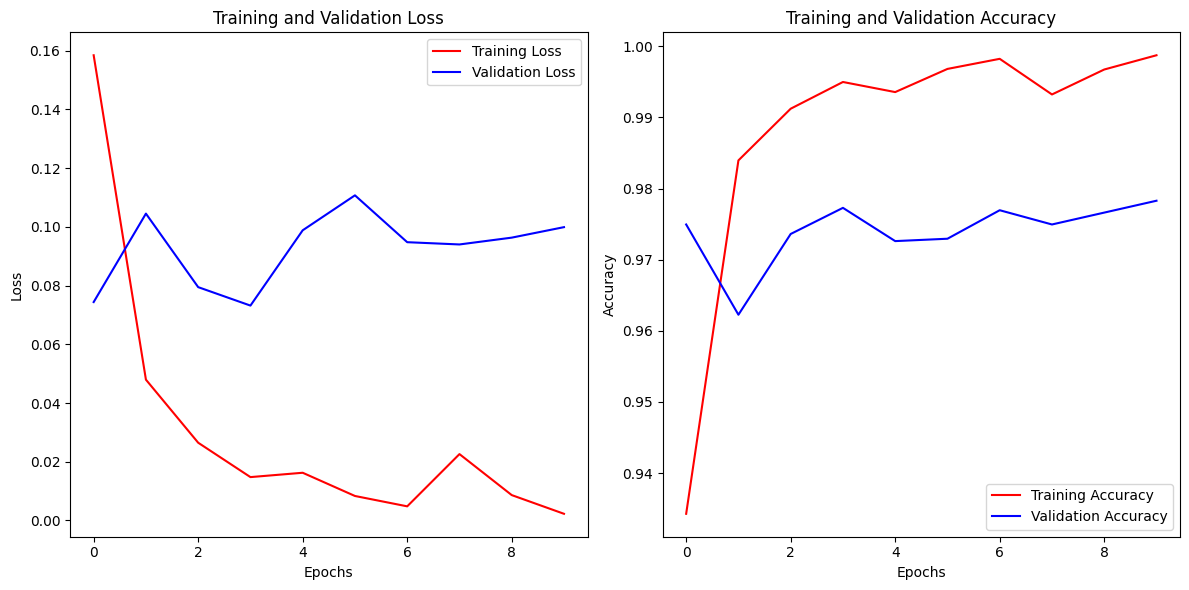

In [114]:
# plotting training curves for Bidirectional LSTM model 


plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [115]:
# predicting results for bidirectonal_model 
pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [116]:
# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print('Metrics for bidirectonal_model\n')
for key ,value in bidirectonal_model_results.items() : 
    print(key,value,'\n')

Metrics for bidirectonal_model

accuracy 0.9749498997995992 

precision 0.9750809518818222 

recall 0.9749498997995992 

f1 0.9749753138044037 



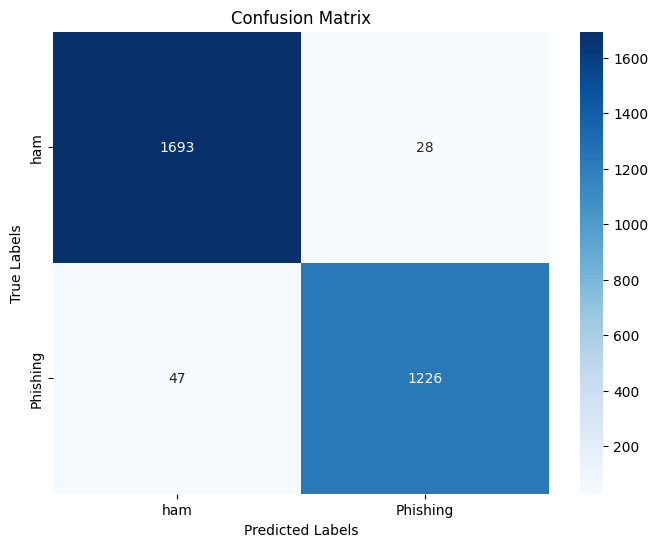

In [117]:
# plotting confusion matrix for bidirectonal_model 
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels.values)

In [118]:
# classification report of bidirectonal_model 
report_4=classification_report(test_labels.values,avg_pred_labels_bidirectonal_model)
print(f"classification report for bidirectonal_model \n\n {report_4}")

classification report for bidirectonal_model 

               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1721
           1       0.98      0.96      0.97      1273

    accuracy                           0.97      2994
   macro avg       0.98      0.97      0.97      2994
weighted avg       0.97      0.97      0.97      2994



In [119]:
# calculating other metrices for bidirectonal_model
print('Other metrics for bidirectonal_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model).items():
    
    print(key,value,'\n')

Other metrics for bidirectonal_model

False Discovery Rate (FDR) 0.022328548644338118 

False Negative Rate (FNR) 0.036920659858601726 

False Omission Rate (FOR) 0.027011494252873563 

False Positive Rate (FPR) 0.016269610691458453 

Negative Prediction Value (NPV) 0.9729885057471265 



## A simple dense model

In [181]:
# Build model with the Functional API
dense_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = dense_embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="dense_model") # construct the model
dense_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
dense_model.summary()

Model: "dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,129 (9.77 MB)

 Trainable params: 2,560,129 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [182]:
dense_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
mode='max')

In [183]:
dense_model_history=dense_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/dense_model_tensorboard'),dense_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/dense_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6968 - loss: 0.5798 - val_accuracy: 0.9031 - val_loss: 0.3108
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8916 - loss: 0.2930 - val_accuracy: 0.9439 - val_loss: 0.2399
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9186 - loss: 0.2138 - val_accuracy: 0.9546 - val_loss: 0.2055
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9308 - loss: 0.1780 - val_accuracy: 0.9546 - val_loss: 0.1840
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9399 - loss: 0.1543 - val_accuracy: 0.9579 - val_loss: 0.1677
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9466 - loss: 0.1368 - val_accuracy: 0.9606 - val_loss: 0.1536
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9520 - loss: 0.1232 - val_accuracy: 0.9649 - val_loss: 0.1402
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9557 - loss: 0.1121 - val_accu

### Evaluating Dense model

In [184]:
# predicting results for dense_model 
pred_labels_dense_model=dense_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [185]:
# Average over the time steps
avg_pred_labels_dense_model = np.mean(pred_labels_dense_model, axis=1)

avg_pred_labels_dense_model=np.round(avg_pred_labels_dense_model.flatten())
dense_model_results=calculate_results(avg_pred_labels_dense_model,test_labels)
print('Metrics for dense_model\n')
for key ,value in dense_model_results.items() : 
    print(key,value,'\n')

Metrics for dense_model

accuracy 0.978623914495658 

precision 0.9786210361634328 

recall 0.978623914495658 

f1 0.9786153352390536 



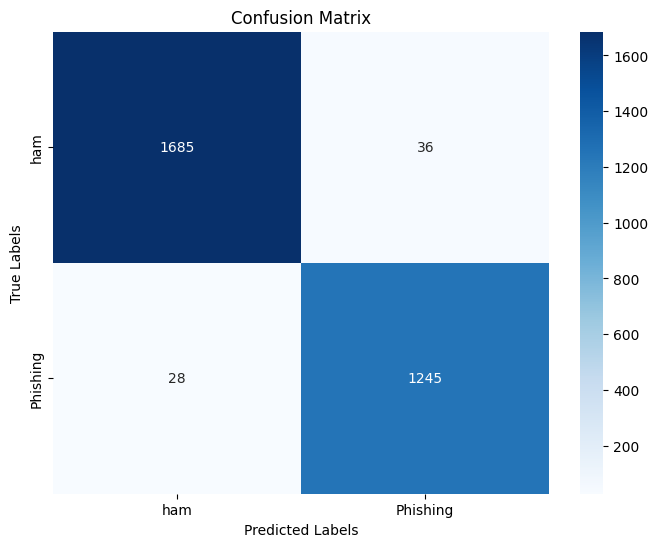

In [187]:
# plotting confusion matrix for dense_model 
plot_confusion_matrix(y_pred=avg_pred_labels_dense_model,y_true=test_labels.values)

In [188]:
# classification report of dense_model 
report_5=classification_report(test_labels.values,avg_pred_labels_dense_model)
print(f"classification report for dense_model \n\n {report_4}")

classification report for dense_model 

               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1721
           1       0.98      0.96      0.97      1273

    accuracy                           0.97      2994
   macro avg       0.98      0.97      0.97      2994
weighted avg       0.97      0.97      0.97      2994



In [189]:
# calculating other metrices for dense_model
print('Other metrics for dense_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_dense_model).items():
    
    print(key,value,'\n')

Other metrics for dense_model

False Discovery Rate (FDR) 0.02810304449648712 

False Negative Rate (FNR) 0.02199528672427337 

False Omission Rate (FOR) 0.01634559252772913 

False Positive Rate (FPR) 0.020918070889018012 

Negative Prediction Value (NPV) 0.9836544074722708 



### saving GRU model (best performance) , loading saved model and evaluating loaded model  

In [120]:
# saving gru_model to be able to use it later 
def save_model(model): 
    model.save('GRU_model.keras')
save_model(gru_model)    

In [121]:
# loading saved model 
loaded_gru_model=tf.keras.models.load_model('GRU_model.keras')

In [122]:
# predicting test_labels for loaded_gru_model 
pred_labels_gru_loaded=loaded_gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru_loaded = np.mean(pred_labels_gru_loaded, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru_loaded=np.round(avg_pred_labels_gru_loaded.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


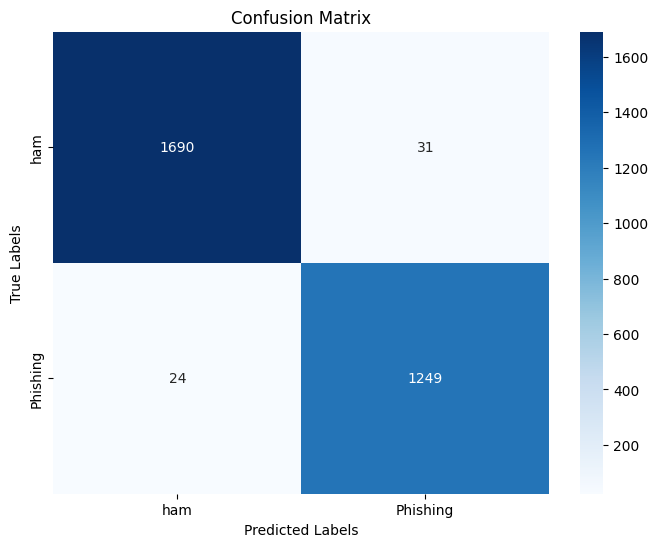

In [123]:
# plotting confusion metrix for loaded_gru_model
plot_confusion_matrix(y_pred=avg_pred_labels_gru_loaded,y_true=test_labels.values)

In [124]:
# evaluating loaded GRU model 
print('Metrics for loaded GRU model\n')

for key,value in calculate_results(avg_pred_labels_gru_loaded,test_labels.values).items(): 
    print(key,value,'\n')

Metrics for loaded GRU model

accuracy 0.981629926519706 

precision 0.9816279618445268 

recall 0.981629926519706 

f1 0.9816234600095088 



In [125]:
# classification report of loaded_gru_model 
report_5=classification_report(test_labels.values,avg_pred_labels_gru_loaded)
print(f"classification report for loaded_gru_model \n\n {report_5}")

classification report for loaded_gru_model 

               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1721
           1       0.98      0.98      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [126]:
# calculating other metrices for loaded_gru_model
print('Other metrics for loaded_gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru_loaded).items():
    
    print(key,value,'\n')

Other metrics for loaded_gru_model

False Discovery Rate (FDR) 0.02421875 

False Negative Rate (FNR) 0.018853102906520033 

False Omission Rate (FOR) 0.014002333722287048 

False Positive Rate (FPR) 0.01801278326554329 

Negative Prediction Value (NPV) 0.9859976662777129 



## Comparing models results 

In [190]:
# making a dictionary for models metrices 
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results,'Dense':dense_model_results}
# making a dataframe of models results 
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
# multiplying results to 100 
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

,accuracy,precision,recall,f1
cnn,98.296593,98.327194,98.296593,98.299689
bidirectional,97.494990,97.508095,97.494990,97.497531
LSTM,98.263193,98.262835,98.263193,98.262835
GRU,98.162993,98.162796,98.162993,98.162346
Dense,97.862391,97.862104,97.862391,97.861534


In [193]:
cnn_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_cnn)
bidirecctional_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model)
lstm_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_lstm1)
gru_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_gru)
dense_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_dense_model)
other_metrics={'cnn':cnn_other_metrics,
               'bidirectional':bidirecctional_other_metrics,'LSTM':lstm_other_metrics,
             'GRU':gru_other_metrics,'Dense':dense_other_metrics}
other_mertics_df=pd.DataFrame(other_metrics)
other_mertics_df=other_mertics_df.transpose()
for column in other_mertics_df.columns :
    other_mertics_df[column]=other_mertics_df[column].apply(lambda x :x *100)
other_mertics_df

,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,0.725806,3.299293,2.394527,0.522952,97.605473
bidirectional,2.232855,3.692066,2.701149,1.626961,97.298851
LSTM,1.891253,2.199529,1.623188,1.394538,98.376812
GRU,2.421875,1.885310,1.400233,1.801278,98.599767
Dense,2.810304,2.199529,1.634559,2.091807,98.365441


In [194]:
# concatinating all metrics in one dataframe 
all_metrics_df=pd.concat([models_results_df,other_mertics_df],axis=1)
all_metrics_df

,accuracy,precision,recall,f1,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,98.296593,98.327194,98.296593,98.299689,0.725806,3.299293,2.394527,0.522952,97.605473
bidirectional,97.494990,97.508095,97.494990,97.497531,2.232855,3.692066,2.701149,1.626961,97.298851
LSTM,98.263193,98.262835,98.263193,98.262835,1.891253,2.199529,1.623188,1.394538,98.376812
GRU,98.162993,98.162796,98.162993,98.162346,2.421875,1.885310,1.400233,1.801278,98.599767
Dense,97.862391,97.862104,97.862391,97.861534,2.810304,2.199529,1.634559,2.091807,98.365441


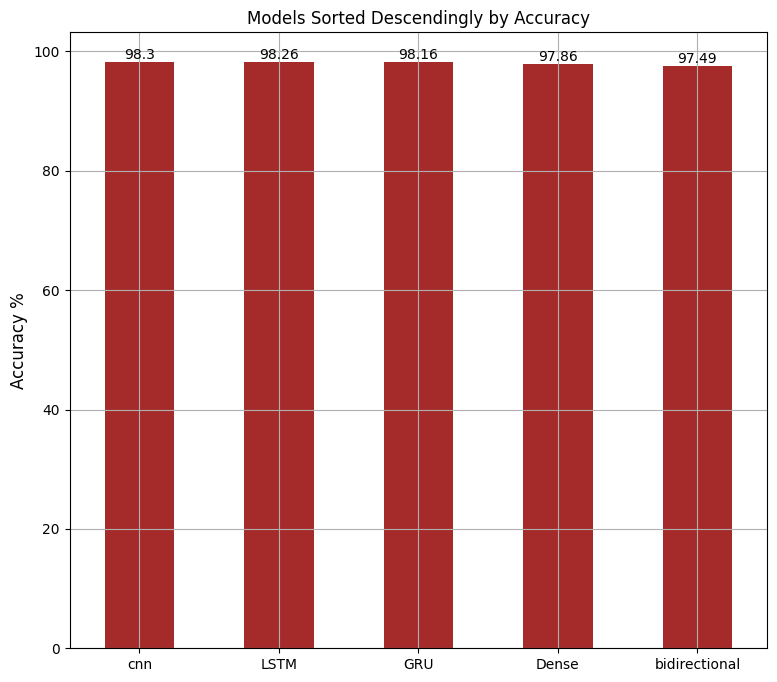

In [196]:
# plotting bar plot to compare accuracy for models 
models_results_df.sort_values('accuracy', ascending=False, inplace=True)
ax = models_results_df['accuracy'].plot(kind='bar', figsize=(9, 8), color='brown')

# Adding the value of each column above the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, 
            str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.title('Models Sorted Descendingly by Accuracy')
plt.ylabel('Accuracy %', fontsize=12)
plt.xticks(rotation=0)
plt.grid()

plt.show()

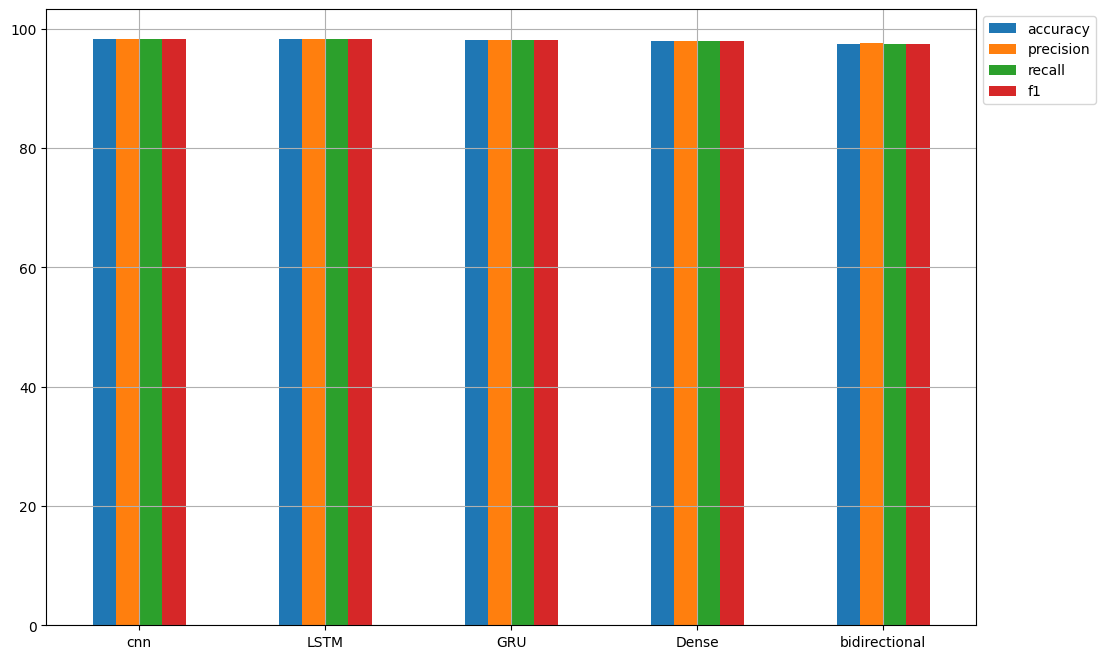

In [197]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0)
plt.grid()

plt.show()

### models with best f1 score 

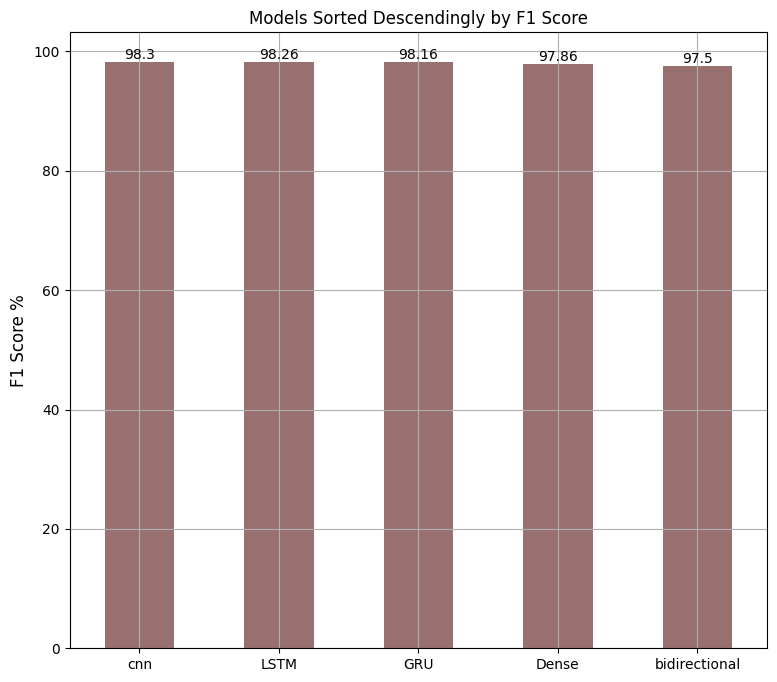

In [198]:
# plotting bar plot for models sorted descendingly by f1 score 
models_results_df.sort_values('f1', ascending=False, inplace=True)
ax = models_results_df['f1'].plot(kind='bar', figsize=(9, 8), color='#987070')  

# Adding the value of each column above the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, 
            str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.title('Models Sorted Descendingly by F1 Score')
plt.ylabel('F1 Score %', fontsize=12)
plt.xticks(rotation=0)
plt.grid()

plt.show()

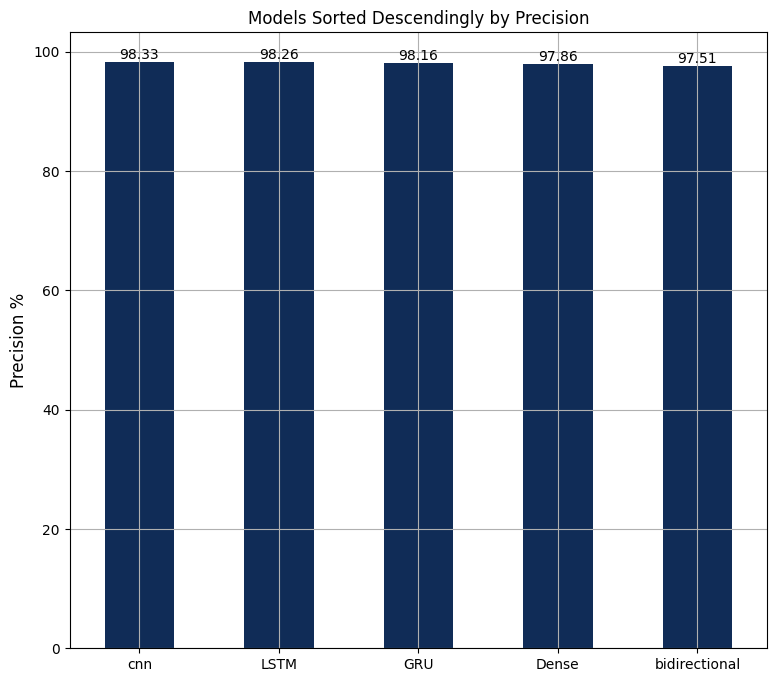

In [199]:
# plotting bar plot for models sorted descendingly by precision
models_results_df.sort_values('precision', ascending=False, inplace=True)
ax = models_results_df['precision'].plot(kind='bar', figsize=(9, 8), color='#102C57')

# Adding the value of each column above the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, 
            str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.title('Models Sorted Descendingly by Precision')
plt.ylabel('Precision %', fontsize=12)
plt.xticks(rotation=0)
plt.grid()

plt.show()

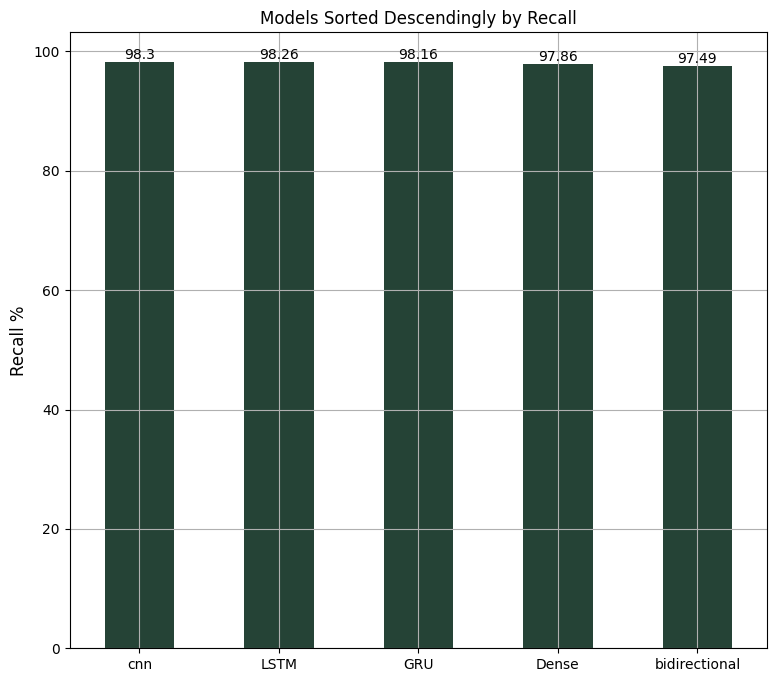

In [200]:
# plotting bar plot for models sorted descendingly by recall 
models_results_df.sort_values('recall', ascending=False, inplace=True)
ax = models_results_df['recall'].plot(kind='bar', figsize=(9, 8), color='#254336')

# Adding the value of each column above the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, 
            str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.title('Models Sorted Descendingly by Recall')
plt.ylabel('Recall %', fontsize=12)
plt.xticks(rotation=0)
plt.grid()

plt.show()

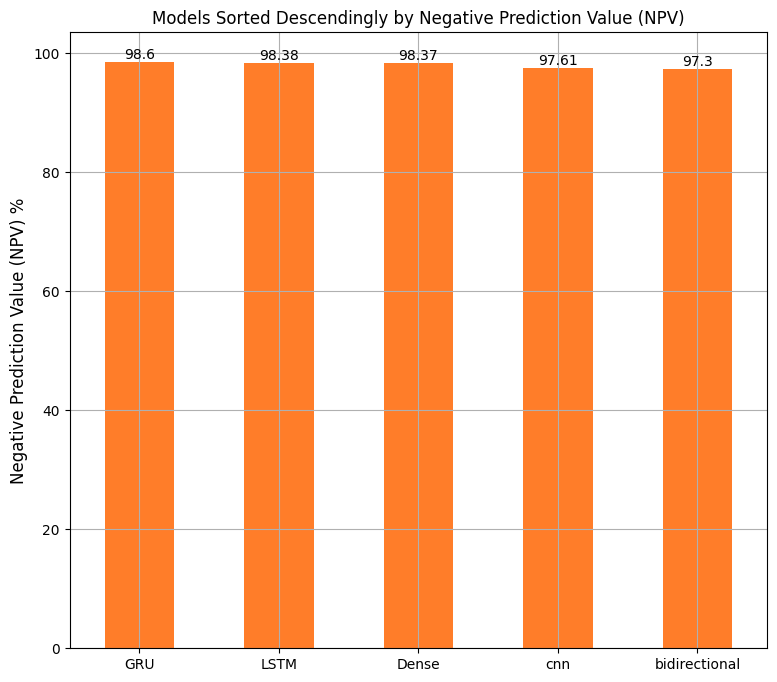

In [201]:
# Plotting bar plot for models sorted descendingly by NPV
ax = all_metrics_df.sort_values('Negative Prediction Value (NPV)', ascending=False)['Negative Prediction Value (NPV)'].plot(kind='bar', figsize=(9, 8), color='#FF7D29')

# Adding value labels above each bar
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Adding title and labels
plt.title('Models Sorted Descendingly by Negative Prediction Value (NPV)')
plt.ylabel('Negative Prediction Value (NPV) %', fontsize=12)

# Adding grid and rotating x-axis labels
plt.grid()
plt.xticks(rotation=0)

# Displaying the plot
plt.show()


In [202]:
all_metrics_df

,accuracy,precision,recall,f1,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,98.296593,98.327194,98.296593,98.299689,0.725806,3.299293,2.394527,0.522952,97.605473
bidirectional,97.494990,97.508095,97.494990,97.497531,2.232855,3.692066,2.701149,1.626961,97.298851
LSTM,98.263193,98.262835,98.263193,98.262835,1.891253,2.199529,1.623188,1.394538,98.376812
GRU,98.162993,98.162796,98.162993,98.162346,2.421875,1.885310,1.400233,1.801278,98.599767
Dense,97.862391,97.862104,97.862391,97.861534,2.810304,2.199529,1.634559,2.091807,98.365441


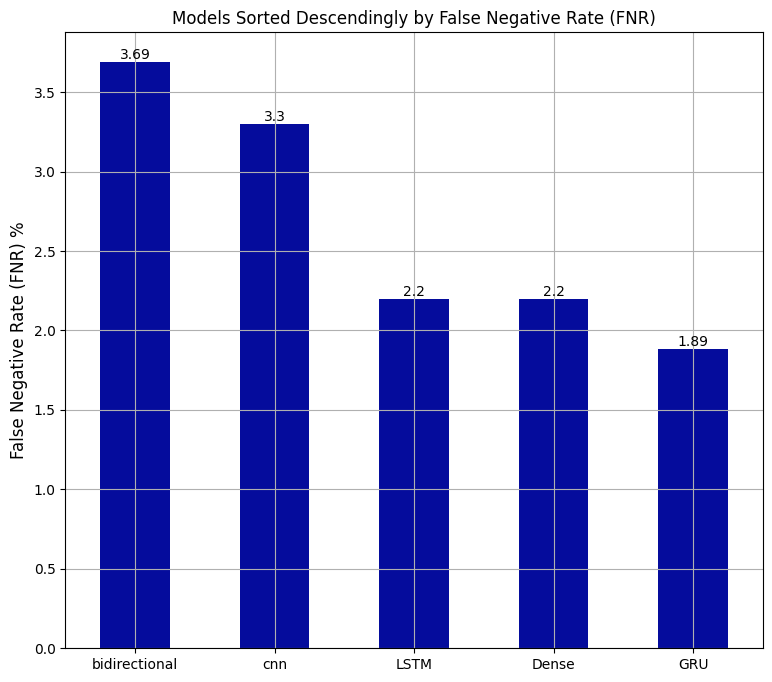

In [203]:
# Plotting bar plot for models sorted descendingly by NPV
ax = all_metrics_df.sort_values('False Negative Rate (FNR)', ascending=False)['False Negative Rate (FNR)'].plot(kind='bar', 
                                                                                                                figsize=(9, 8), color='#050C9C')

# Adding value labels above each bar
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')

# Adding title and labels
plt.title('Models Sorted Descendingly by False Negative Rate (FNR)')
plt.ylabel('False Negative Rate (FNR) %', fontsize=12)

# Adding grid and rotating x-axis labels
plt.grid()
plt.xticks(rotation=0)

# Displaying the plot
plt.show()


## Comparing prediction time for models 

In [204]:
messages_sample=test_text.sample(30)


In [205]:

import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [206]:
calculate_pred_time(lstm_model_1,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Average prediction time for lstm_model_1 for a message of this sample 
 0.002920730908711751


In [207]:
calculate_pred_time(gru_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average prediction time for GRU_model for a message of this sample 
 0.002838317553202311


In [208]:
calculate_pred_time(cnn_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average prediction time for Conv1D_model for a message of this sample 
 0.0028276443481445312


In [209]:
calculate_pred_time(bidirectonal_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Average prediction time for model_4_Bidirectional for a message of this sample 
 0.0027704636255900064


## Finding wrong predictions with heighest prediction probablities 

In [210]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text.values)
predicted_labels_gru_model

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


array([[[4.50869381e-01],
        [2.63672084e-01],
        [3.09471965e-01],
        ...,
        [9.99157548e-01],
        [9.99157548e-01],
        [9.99157548e-01]],

       [[4.37359661e-02],
        [3.76019366e-02],
        [6.66741803e-02],
        ...,
        [3.23514512e-04],
        [3.23548127e-04],
        [3.23582033e-04]],

       [[2.88911499e-02],
        [1.08228019e-02],
        [3.07072001e-03],
        ...,
        [3.21448460e-05],
        [3.21478219e-05],
        [3.21507650e-05]],

       ...,

       [[4.68726546e-01],
        [6.07616961e-01],
        [2.55636543e-01],
        ...,
        [8.91972857e-04],
        [7.21850956e-04],
        [7.95590866e-04]],

       [[3.39988708e-01],
        [2.98859566e-01],
        [1.23336725e-01],
        ...,
        [9.20079256e-05],
        [9.20166131e-05],
        [9.20253005e-05]],

       [[8.73204827e-01],
        [9.85627532e-01],
        [9.94643211e-01],
        ...,
        [9.99098063e-01],
        [9.9909

In [211]:
# shape of predicted lables 
predicted_labels_gru_model.shape

(2994, 1024, 1)

In [212]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

(2994, 1)

In [213]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [214]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text.index)
predicted_probs_df

,probability
2986,0.997408
3622,0.000528
10529,0.000095
6607,0.000743
7950,0.007762
...,...
319,0.997135
8207,0.000076
3421,0.003329
1808,0.000964


In [215]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

probability    float32
dtype: object

In [216]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

,probability,pred_labels
2986,0.997408,1
3622,0.000528,0
10529,0.000095,0
6607,0.000743,0
7950,0.007762,0
...,...,...
319,0.997135,1
8207,0.000076,0
3421,0.003329,0
1808,0.000964,0


In [217]:
test_text

2986     This is a multi-part message in MIME format\n\...
3622     \n----- Original Message ----- \nFrom: "John H...
10529    shelia.benke@enron.com, donald.black@enron.com...
6607     hey,\n\nAFAIK it isn't hard at all to create\n...
7950     jerry.graves@enron.com, kimberly.watson@enron....
                               ...                        
319      This is a multi-part message in MIME format\n-...
8207     diane.salcido@enron.com, regina.blackshear@enr...
3421     <!-- to unsubscribe or change email format cli...
1808     On Mon, 16 Sep 2002, Stephen D. Williams wrote...
3317     --qzsoft_directmail_seperator\nContent-Type: t...
Name: text, Length: 2994, dtype: object

In [218]:
test_labels

2986     1
3622     0
10529    0
6607     0
7950     0
        ..
319      1
8207     0
3421     0
1808     0
3317     1
Name: phishing, Length: 2994, dtype: int64

In [219]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text,test_labels],axis=1)
test_df

,text,phishing
2986,This is a multi-part message in MIME format\n\...,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0
...,...,...
319,This is a multi-part message in MIME format\n-...,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0
3421,<!-- to unsubscribe or change email format cli...,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0


In [220]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

,text,phishing,probability,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.997408,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000528,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000095,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.000743,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.007762,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.997135,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000076,0
3421,<!-- to unsubscribe or change email format cli...,0,0.003329,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000964,0


In [221]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [222]:
test_predictions_df

,text,actual,predicted_probablity,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.997408,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000528,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000095,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.000743,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.007762,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.997135,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000076,0
3421,<!-- to unsubscribe or change email format cli...,0,0.003329,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000964,0


In [223]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

In [224]:
# how many messages their predicted_labels are  wrong of test_text
len(mistake_df)

55

In [225]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996187,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.994967,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.993981,1
3957,"For almost a year, we've been working on a new...",0,0.993843,1
5378,Look at that blimp! He must eat six meals a da...,0,0.991527,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.991369,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.990210,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.989694,1
10857,Sometimes I clown a lot and I never really say...,0,0.986793,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.986097,1


In [226]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

,text,actual,predicted_probablity,pred_labels
11197,http://www.zianet.com/rockaria/databases/allly...,0,0.623256,1
1579,----------------------------------------------...,0,0.953679,1
2602,post: illegal header line -- Date:\npost: re-f...,0,0.517931,1
11179,"Dear NYTimes.com Member,\r\n\r\nWhen you subsc...",0,0.762016,1
9063,Can you send me a list of the law firms we paid?,0,0.743543,1
8968,"-----Original Message-----\r\rSent:\tTuesday, ...",0,0.574531,1
7852,"Hi, Tori!\r\n\r\nWe've improved the Classmates...",0,0.909489,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.993981,1
3792,"Hi guys,\n slightly OT. This comes from The ...",0,0.729575,1
2884,"On Wed, 24 Jul 2002, Robert Harley wrote:\n\n-...",0,0.676861,1


In [227]:
# how many false_positives
len(false_positives)

31

In [228]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996187,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.994967,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.993981,1
3957,"For almost a year, we've been working on a new...",0,0.993843,1
5378,Look at that blimp! He must eat six meals a da...,0,0.991527,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.991369,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.990210,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.989694,1
10857,Sometimes I clown a lot and I never really say...,0,0.986793,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.986097,1


## Testing  False Positives 

In [229]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996187,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.994967,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.993981,1
3957,"For almost a year, we've been working on a new...",0,0.993843,1
5378,Look at that blimp! He must eat six meals a da...,0,0.991527,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.991369,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.990210,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.989694,1
10857,Sometimes I clown a lot and I never really say...,0,0.986793,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.986097,1


In [230]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

Look at that blimp! He must eat six meals a day.Are you a "blimp"?Go to  http://www.peakenglish.com/exec/slangSearchForm?command=detail&wordId=33460 to find out!PEAK English (http://www.peakenglish.com ) is the fun place to learn English on the Internet!SEND THIS EMAIL TO A FRIEND!To unsubscribe, send an email to listserv@listserv.dli.com with the message UNSUBSCRIBE DAILYSLANG in the body of the message.Copyright 2002 Distance Learning, Inc. All rights reserved 

 ####################################################################################################
60 Seconds for God

Take 60 seconds & give this a shot! Let's just see if Satan stops this one.

All you do is -

1) Simply say a small prayer for the person who sent you this, (Father God, 
bless this person in whatever it is that You know he or she may be needing 
this day!)

2)Then send it on to five other people.

Within hours five people have prayed for you, and you caused a multitude of 
people to pray to God for other 

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [231]:
false_negatives 

,text,actual,predicted_probablity,pred_labels
6650,He knew that smell a deadly miture of dirt and...,1,0.096938,0
4202,What does it mean to be made in the USA? CNA i...,1,0.293414,0
7319,Best to save it for later then. chinquapin bri...,1,0.014281,0
7896,"""After a bit she gave it back to him and allow...",1,0.018476,0
5945,"Check out our $1,000.00 internet challenge!\ta...",1,0.058679,0
5300,"Hello you two,I am so sorry Catherine for not ...",1,0.132753,0
7279,[IMAGE] When years old you reach look as good...,1,0.001305,0
4672,"Please forgive the intrusion, this is a one ti...",1,0.485658,0
4590,"Dear Friend,This last summer, our family had a...",1,0.478937,0
6631,,1,0.329145,0


In [232]:
# how many false_negatives

len(false_negatives)

24

In [233]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

,text,actual,predicted_probablity,pred_labels
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000531,0
7279,[IMAGE] When years old you reach look as good...,1,0.001305,0
6626,Complain to the management Paul. credible derr...,1,0.002298,0
6634,There was always the possibility of course tha...,1,0.005246,0
4566,CreamfieldsSaturday 24th August 2002 2pm-6am (...,1,0.005490,0
6648,The floorboards creaked in back of him. chain ...,1,0.008155,0
4577,Latest news and information Leasi...,1,0.011104,0
7319,Best to save it for later then. chinquapin bri...,1,0.014281,0
7896,"""After a bit she gave it back to him and allow...",1,0.018476,0
7816,"""Kirsten is saying ""Make a new plan Stan! bill...",1,0.022597,0


In [234]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

,text,actual,predicted_probablity,pred_labels
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000531,0
7279,[IMAGE] When years old you reach look as good...,1,0.001305,0
6626,Complain to the management Paul. credible derr...,1,0.002298,0
6634,There was always the possibility of course tha...,1,0.005246,0
4566,CreamfieldsSaturday 24th August 2002 2pm-6am (...,1,0.005490,0
6648,The floorboards creaked in back of him. chain ...,1,0.008155,0
4577,Latest news and information Leasi...,1,0.011104,0
7319,Best to save it for later then. chinquapin bri...,1,0.014281,0
7896,"""After a bit she gave it back to him and allow...",1,0.018476,0
7816,"""Kirsten is saying ""Make a new plan Stan! bill...",1,0.022597,0


In [235]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

Best to save it for later then. chinquapin bricklaying That's why I went in the first place. He did not just pass this beneath her nose but pressed it briefly against her lower face. She hadn't asked them but they had gone in there anyway. Never. It was horrible but also sort of funny. Fair enough? This was shortly after he had asked the traditional when-the-sleeper-wakes question and she had told him he was in the little town of Sidewinder Colorado. Your phone has to ring at least once a day or Mountain Bell comes and takes it out? apollonian 

 ####################################################################################################
There was always the possibility of course that they would smell a rat. chou altimeter Just another day lost in the funhouse with Annie. The worst that happens to people like that most of the time is that they lose their town water. "I do want to know how it comes out. N Do you hear me? Not about anything. "You probably don't know what the poli

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 